In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from sat_pred.dataloader import SatelliteDataset, SatelliteDataModule

torch.manual_seed(0)
np.random.seed(0)

In [3]:
# Instantiate the torch dataset object
dataset = SatelliteDataset(
    zarr_path="path/to/new/satellite/directory/2020_nonhrv.zarr",
    start_time="2020-06-01",
    end_time="2020-06-15",
    history_mins=60, 
    forecast_mins=120, 
    sample_freq_mins=5,
)

In [4]:
# Number of complete samples in the dataset 
# - this includes overlapping periods, not completely distinct periods
n_samples = len(dataset)
print(n_samples)

4237


In [5]:
# Speed test
%timeit -n 3 -r 10 dataset[np.random.randint(n_samples)]

724 ms ± 71.7 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)


In [6]:
# Index out a single sample
X, y = dataset[100]

In [7]:
type(X)

numpy.ndarray

In [8]:
X.shape # (channels, time, height, width)

(11, 13, 372, 614)

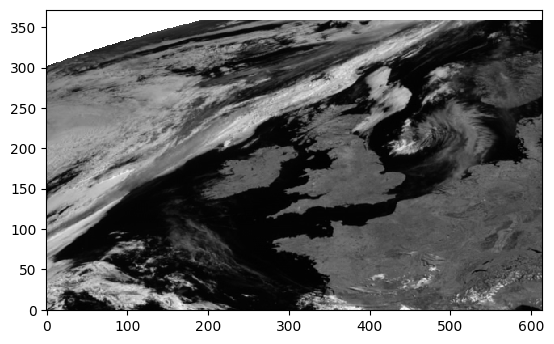

In [9]:
# Slice a single image from the input data and select a single channel
# The channel at index 8 is the VIS008 visual channel
single_image = X[0, 8]

# Need to reverse the x-axis since the data is reversed in this dimension on disk
single_image = single_image[:, ::-1]

plt.imshow(single_image, cmap='gist_grey', interpolation='nearest', origin="lower")
plt.show()

In [10]:
# Instantiate a lightning datamodule
datamodule = SatelliteDataModule(
    zarr_path="/mnt/disks/bigbatches/sat_test/2020_nonhrv.zarr",
    history_mins=60, 
    forecast_mins=120, 
    sample_freq_mins=5,
    batch_size=16,
    num_workers=8,
    prefetch_factor=2,
    train_period=["2020-06-01", "2020-06-19"],
    val_period=["2020-06-20", "2020-06-25"],
    test_period=["2020-06-26", "2020-06-30"],
)

In [11]:
# Instantiate the train dataloader
train_dataloader = datamodule.train_dataloader()

In [12]:
# Speed test of the dataloader
import time

t_last = time.time()
for i, (X, y) in zip(range(20), train_dataloader):
    t_now = time.time()
    print(f"Batch {i} took : {t_now-t_last:.3f} seconds")
    t_last = t_now

Batch 0 took : 25.732 seconds
Batch 1 took : 5.139 seconds
Batch 2 took : 0.414 seconds
Batch 3 took : 0.319 seconds
Batch 4 took : 0.324 seconds
Batch 5 took : 0.312 seconds
Batch 6 took : 0.329 seconds
Batch 7 took : 0.318 seconds
Batch 8 took : 16.046 seconds
Batch 9 took : 2.702 seconds
Batch 10 took : 0.268 seconds
Batch 11 took : 0.292 seconds
Batch 12 took : 0.292 seconds
Batch 13 took : 0.319 seconds
Batch 14 took : 0.364 seconds
Batch 15 took : 0.332 seconds
Batch 16 took : 16.788 seconds
Batch 17 took : 4.929 seconds
Batch 18 took : 0.319 seconds
Batch 19 took : 0.304 seconds


In [13]:
type(X)

torch.Tensor

In [14]:
X.shape # (batch size, channels, time, height, width)

torch.Size([16, 11, 13, 372, 614])

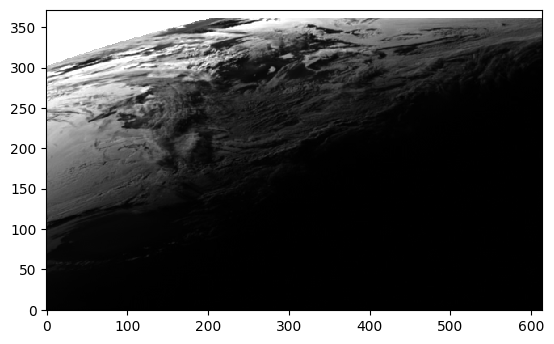

In [15]:
# Slice the VIS008 channel from a single image from the input data
single_image = X[1, 0, 8].numpy()

# Need to reverse the x-axis since the data is reversed in this dimension on disk
single_image = single_image[:, ::-1]

plt.imshow(single_image, cmap='gist_grey', interpolation='nearest', origin="lower")
plt.show()

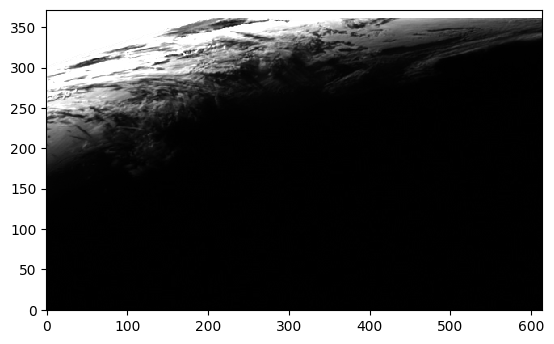

In [16]:
# Slice the accompanying target for the above
single_image = y[1, 0, 8].numpy()

single_image = single_image[:, ::-1]

plt.imshow(single_image, cmap='gist_grey', interpolation='nearest', origin="lower")
plt.show()

Looks like this example was towards dusk. Channel 8 which we plotted above is one of the visual channels, but other channels are still active at night

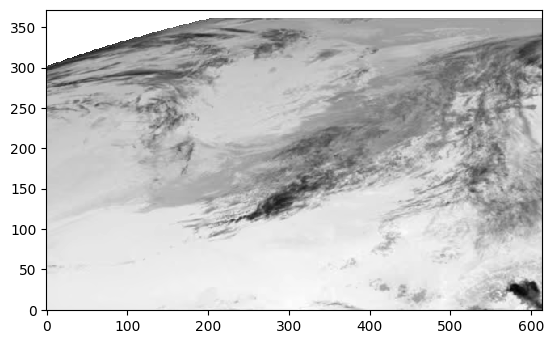

In [17]:
# Select one of the infrared channels for the image above
# the channel at index 2 is the IR_087 channel
single_image = y[1, 2, 0].numpy()
single_image = single_image[:, ::-1]

plt.imshow(single_image, cmap='gist_grey', interpolation='nearest', origin="lower")
plt.show()